Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Ariana Familiar"
# COLLABORATORS = ""

---

# Homework 2, Basic Part: Big Data and Graph Data
## Due October 15, 2018 by 10pm
### Worth 100 points in total

For this assignment, we will focus on graph data.  You saw an instance of this with Homework 1 -- the airline flight network is actually a graph -- but we only did limited kinds of computation over the graph.  However, many real-world datasets are, or can be modeled by, graphs (or trees which are special cases of graphs).  Examples include:

* Networks (social networks, the Web, the connectome, the Internet, traffic networks, …)
* Sets of data in which some of the data is more closely connected than other parts of the data (edges may represent weighted similarity or affinity)
* Phylogenetic trees, grammars, etc.

For this assignment, we will be doing a few common operations on graphs.  In the next assignment, when we have the power of matrices, we will do some further computation over the same graph data.  (It’s very common to encode graph connectivity through an adjacency matrix that we’ll discuss in lecture.)


*Submission*. See the external document for submission information.  Remember to also do **Homework 2-Advanced**.

## 2. Getting Started with Apache Spark (within Docker)

Apache Spark, which has become the de facto successor to Apache Hadoop, is a complex, cluster-based data processing system that was written in Scala.  It leverages a wide variety of distributed tools and components used for big data processing.  It interfaces “smoothly” to Python, but be forewarned that there are some rough edges.  For those interested in why, there are a few reasons:

* Scala has slightly different notions of types (especially things like Rows) and handles missing values (nulls) differently from Python.
* The Scala-based Spark “engine” can’t just run Python functions as it’s doing data processing.  This means that you want to be careful to use Spark’s library of functions, or the special mechanisms for inserting “user defined functions.”
* DataFrames on Spark are “sharded,” so there is no single object corresponding to the DataFrame!

While Spark DataFrames try to emulate the same programming style as Pandas DataFrames, there are some differences in how you express things.  Please refer to the Lecture Slides for our take on the differences.  You may also find the following Web pages to be useful resources for understanding Spark vs Pandas DataFrames:

https://lab.getbase.com/pandarize-spark-dataframes/
https://ogirardot.wordpress.com/2015/07/31/from-pandas-to-apache-sparks-dataframe/ 

For this assignment, we are going to get familiar with Spark without worrying too much about sharding and distribution.  We are going to run Spark on your Docker container.  This isn’t really using it to its strengths -- and in fact you might find Spark to be unexpectedly slow -- but it will get you comfortable with programming in Spark without worrying about distributed nodes, clusters, and spending real dollars on the cloud.  Your code, if written properly, will “naturally scale” to clusters running on the Cloud.  Later in the term we’ll connect your Jupyter instance to Spark running on the cloud -- to handle “truly big data.”


### Step 2.1 Initializing a Connection to Spark

We'll open a connection to Spark as follows. Note that Spark has multiple interfaces, as you will see if you look at sample code elsewhere. `SparkSession` is the “most modern” one and we’ll be using it for this course.  From `SparkSession`, you can load data into Spark DataFrames as well as `RDD`s.

In [2]:
# If you want to run from an environment outside of the Docker container you'll need to uncomment 
# and run this.  Otherwise you can skip through.
# ! pip install pyspark --user
# ! pip install seaborn --user
# ! pip install plotly --user
# ! pip install imageio --user
# ! pip install folium --user
# ! pip install heapq

import numpy as np
import pandas as pd

#misc
import gc
import time
import warnings


#viz
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 

# graph viz
import plotly.offline as pyo
from plotly.graph_objs import *
import plotly.graph_objs as go

#map section
import imageio
import folium
import folium.plugins as plugins
# from mpl_toolkits.basemap import Basemap


#graph section
import networkx as nx
import heapq  # for getting top n number of things from list,dict

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os
# make sure pyspark tells workers to use python3 not 2 if both are installed
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
# os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/ipython3'

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()


### Step 2.2 Download data

The following code retrieves the Yelp dataset in a zipfile and decompresses it.  It will take quite a while - you may want to take a break while it runs.

In [4]:
# Based on https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url

import zipfile
import urllib.request
import shutil
import os

def get_and_unzip(url,file_name):
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        with zipfile.ZipFile(file_name) as zf:
            zf.extractall()

if not os.path.exists("data"):
    os.mkdir("data")
    os.chdir("data")
    get_and_unzip("http://www.cis.upenn.edu/~cis545/yelp-dataset.zip","yelp-dataset.zip")
    os.chdir("..")


### Step 2.3 Load Our Graph Datasets.

For this assignment, we’ll be looking at graph data (reviews, reviewers, businesses) downloaded from Yelp.

**A very brief review of graph theory**. Recall that a graph $G$ is composed of a set of vertices $V$ (also called nodes) and edges $E$ (sometimes called links).  Each vertex $v \in V$ has an identity (often represented in the real world as a string or numeric “node ID”).  Each edge $e \in E$ is a tuple $(v_i,...,v_j)$ where $v_i$ represents the source or origin of the edge, and $v_j$ represents the target or destination.  In the simplest case, the edge tuple above is simply the pair $(v_i,v_j)$ but in many cases we may have additional fields such as a label or a distance.  Recall also that graphs may be undirected or directed; in undirected graphs, all edges are symmetric whereas in directed graphs, they are not.  For instance, airline flights are directed, whereas Facebook friend relationships are undirected.

Let’s read our social graph data from Yelp, which forms a directed graph.  Here, the set of nodes is also not specified; the assumption is that the only nodes that matter are linked to other nodes, and thus their IDs will appear in the set of edges.  To load the file `input.txt` into a Spark DataFrame, you can use lines like the following.

```
# Read lines from the text file
input_sdf = spark.read.load('input.txt', format="text")
```

We’ll use the suffix `_sdf` to represent “Spark DataFrame,” much as we used `_df` to denote a Pandas DataFrame in Homework 1.  Load the various files from Yelp.

Your datasets should be named `yelp_business_sdf`, `yelp_business_attributes_sdf`, `yelp_business_horus_sdf`, `yelp_check_in_sdf`, `yelp_reviews_sdf`, and `yelp_users_sdf`.

In [5]:
# TODO: load Yelp datasets

# Worth 1 point per successful load, 5 additional points if valid schema

# YOUR CODE HERE
# load into spark dataframes
yelp_business_sdf = spark.read.load('data/yelp_business.csv', format="csv", header='true', inferSchema='true')
yelp_business_attributes_sdf = spark.read.load('data/yelp_business_attributes.csv', format="csv", header='true', inferSchema='true')
yelp_business_hours_sdf = spark.read.load('data/yelp_business_hours.csv', format="csv", header='true', inferSchema='true')
yelp_check_in_sdf = spark.read.load('data/yelp_checkin.csv', format="csv", header='true', inferSchema='true')
yelp_reviews_sdf = spark.read.load('data/yelp_review2.csv', format="csv", header='true', inferSchema='true')
yelp_users_sdf = spark.read.load('data/yelp_user.csv', format="csv", header='true', inferSchema='true')

# fix incorrect schema
yelp_business_sdf.createOrReplaceTempView("yelp_business")
yelp_business_sdf = spark.sql('SELECT business_id, name, neighborhood, address, city, '\
                                      'state, cast(postal_code as int) postal_code, latitude, '\
                                      'longitude, stars, review_count, is_open, categories '\
                              'FROM yelp_business')
yelp_check_in_sdf.createOrReplaceTempView("yelp_check_in")
yelp_check_in_sdf = spark.sql('SELECT business_id, weekday, cast(hour as timestamp) hour, '\
                                      'checkins FROM yelp_check_in')
yelp_reviews_sdf.createOrReplaceTempView("yelp_reviews")
yelp_reviews_sdf = spark.sql('SELECT review_id, user_id, business_id, cast(stars as int) stars, '\
                                     'cast(date as timestamp) date, text, cast(useful as int) useful, '\
                                     'cast(funny as int) funny, cast(cool as int) cool FROM yelp_reviews')

In [6]:
yelp_business_sdf.show(10)

+--------------------+--------------------+------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|                name|neighborhood|             address|          city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|    Dental by Design|        null|4855 E Warner Rd,...|     Ahwatukee|   AZ|      85044|   33.3306902|  -111.9785992|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...| Stephen Szabo Salon|        null|  3101 Washington Rd|      McMurray|   PA|      15317|   40.2916853|   -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|Western Motor Veh...|        null|6025

In [7]:
yelp_reviews_sdf.show(10)

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|               date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28 00:00:00|Super simple plac...|     0|    0|   0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28 00:00:00|Small unassuming ...|     0|    0|   0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28 00:00:00|Lester's is locat...|     0|    0|   0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28 00:00:00|Love coming here....|     0|    0|   0|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28 00:00:00|

In [8]:
yelp_business_hours_sdf.show(10)

+--------------------+---------+---------+---------+---------+---------+---------+---------+
|         business_id|   monday|  tuesday|wednesday| thursday|   friday| saturday|   sunday|
+--------------------+---------+---------+---------+---------+---------+---------+---------+
|FYWN1wneV18bWNgQj...|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|     None|     None|
|He-G7vWjzVUysIKrf...| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-16:0| 8:0-16:0|     None|
|KQPW8lFf1y5BT2Mxi...|     None|     None|     None|     None|     None|     None|     None|
|8DShNS-LuFqpEWIp0...|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|11:0-19:0|
|PfOCPjBrlQAnz__NX...| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-2:0| 11:0-0:0|
|o9eMRCWt5PkpLDE0g...| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0|     None|
|kCoE3jvEtg6UVz5SO...| 8:0-17:0| 8:0-17:0| 8:0-17:0| 8:0-17:0| 8:0-17:0|     None|     None|
|OD2hnuuTJI9uotcKy...|11:0-19:0|11:0-19:0|11:0-19:0|11:0-19:0|11:0-19:

In [9]:
yelp_business_attributes_sdf.show(10)

+--------------------+----------------+-----------------+--------------------------+----------------------+----------------------+-------------------------+-------------------+---------------------+--------------------------+---------------------------------+-----------------------+-----------------------+----------------------+----------------------------+-----------------------+-------------------------------+----------------------+-----------+--------------------+-----------+-------+-----+----------+-----------------+--------+----------------------+--------------+-------------+----------+-----------+-------------+-----------------+-----------------+---------------+----------------+--------------+-----------------+---------------+----------------+---------------+------------------------+------+----+-----------------------+------------------+---------+--------------+-----------------------+--------------+-------------------+-----------------+------------------+-----------------+------

In [10]:
yelp_check_in_sdf.show(10)

+--------------------+-------+-------------------+--------+
|         business_id|weekday|               hour|checkins|
+--------------------+-------+-------------------+--------+
|3Mc-LxcqeguOXOVT_...|    Tue|2018-11-26 00:00:00|      12|
|SVFx6_epO22bZTZnK...|    Wed|2018-11-26 00:00:00|       4|
|vW9aLivd4-IorAfSt...|    Tue|2018-11-26 14:00:00|       1|
|tEzxhauTQddACyqdJ...|    Fri|2018-11-26 19:00:00|       1|
|CEyZU32P-vtMhgqRC...|    Tue|2018-11-26 17:00:00|       1|
|9dn5pee_n2dWQfN57...|    Sun|2018-11-26 03:00:00|       5|
|6Zk5F7fsTr8n2CJTl...|    Wed|2018-11-26 01:00:00|       4|
|OE_IDW5w_W97sBcZv...|    Sat|2018-11-26 01:00:00|       1|
|gy5pr5bFAjOL5rERS...|    Sat|2018-11-26 15:00:00|       1|
|r2-eAhGANXlcgQy89...|    Mon|2018-11-26 19:00:00|       1|
+--------------------+-------+-------------------+--------+
only showing top 10 rows



In [11]:
yelp_users_sdf.show(10)

+--------------------+-------+------------+-------------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|             user_id|   name|review_count|      yelping_since|             friends|useful|funny|cool|fans|elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|
+--------------------+-------+------------+-------------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|JJ-aSuM4pCFPdkfoZ...|  Chris|          10|2013-09-24 00:00:00|0

In [12]:
yelp_reviews_sdf.dtypes

[('review_id', 'string'),
 ('user_id', 'string'),
 ('business_id', 'string'),
 ('stars', 'int'),
 ('date', 'timestamp'),
 ('text', 'string'),
 ('useful', 'int'),
 ('funny', 'int'),
 ('cool', 'int')]

In [13]:
if yelp_reviews_sdf.dtypes[0][1] != 'string':
    raise ValueError('Unexpected datatype on ' + yelp_reviews.dtypes[0][0])
    


### Step 2.4 Simple Wrangling in Spark DataFrames

Currently, some of the data from the Yelp dataset is a bit ugly.

You should:

* Clean `yelp_business_hours` so `"None"` is replaced by a Spark `null`.
* Clean `yelp_users` so `"None"` is replaced by a Spark `null`.



First, create SQL tables for each of your Spark DataFrames.  Take the same names as you've used previously, except remove the `_sdf` suffix.

In [14]:
# TODO: save tables with names such as yelp_business, yelp_users

# Worth 5 points if done successfully

# YOUR CODE HERE
yelp_business_sdf.createOrReplaceTempView("yelp_business")
yelp_business_hours_sdf.createOrReplaceTempView("yelp_business_hours")
yelp_check_in_sdf.createOrReplaceTempView("yelp_check_in")
yelp_reviews_sdf.createOrReplaceTempView("yelp_reviews")
yelp_users_sdf.createOrReplaceTempView("yelp_users")


In [15]:
if spark.sql('SELECT COUNT(*) AS count FROM yelp_business').take(1)[0]['count'] != 174567:
    raise ValueError("Unexpected count or table not found")
    

Now you'll need to define a **user-defined function** `replace_none_with_null` to apply to your string fields.  It should take a string parameter and compare it with `None` and `Na`.  If there is a match to either, it should return the Python None value (which will become a Spark null), otherwise it shoudl return the value.

In [16]:
# Define your function here.
# Worth 7 points if done successfully

def replace_none_with_null(x):
# YOUR CODE HERE
    if x == 'None' or x == 'Na':
        return None
    else:
        return x

In [17]:
if replace_none_with_null('None'):
    raise ValueError('Your function does not work')
    
if not replace_none_with_null('x'):
    raise ValueError('Your function does not work')


In [18]:
# Wrap the Python code in a Spark UDF

# We're providing this since it's basically a template

from pyspark.sql.functions import udf
import pyspark.sql.types

spark.udf.register("replace_none_with_null", replace_none_with_null)

spark_replace_none_with_null = udf(replace_none_with_null, pyspark.sql.types.StringType())

Now use `replace_with_none` in SQL, or `spark_replace_none_with_null` if you prefer Pandas-style Spark statements, to clean the data as described above.

In [55]:
# TODO: Clean yelp_business_hours_sdf

# Worth 5 points for each of the two tables specified in 2.4 instructions, if done successfully

# YOUR CODE HERE
yelp_business_hours_sdf = spark.sql('SELECT replace_none_with_null(business_id) as business_id, '\
                                            'replace_none_with_null(monday) as monday, '\
                                            'replace_none_with_null(tuesday) as tuesday, '\
                                            'replace_none_with_null(wednesday) as wednesday, '\
                                            'replace_none_with_null(thursday) as thursday, '\
                                            'replace_none_with_null(friday) as friday, '\
                                            'replace_none_with_null(saturday) as saturday, '\
                                            'replace_none_with_null(sunday) as sunday '\
                                    'FROM yelp_business_hours')

yelp_business_hours_sdf.createOrReplaceTempView("yelp_business_hours")

In [56]:
if spark.sql('select count(*) as count from yelp_business_hours where wednesday=\'None\'').take(1)[0]['count'] > 0:
    raise ValueError('Did not successfully clean business hours')
    

In [57]:
### BEGIN HIDDEN TESTS
if spark.sql('SELECT COUNT(*) AS count FROM yelp_business_attributes').take(1)[0]['count'] != 152041:
    raise ValueError("Unexpected count or table not found")
### END HIDDEN TESTS

AnalysisException: 'Table or view not found: yelp_business_attributes; line 1 pos 30'

In [21]:
# TODO: Clean yelp_users, which has schema
# |user_id|   name|review_count|yelping_since|             friends|useful|funny|cool|fans|elite|average_stars|compliment_hot
# |compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool
# |compliment_funny|compliment_writer|compliment_photos|

# YOUR CODE HERE
yelp_users_sdf = spark.sql('SELECT replace_none_with_null(user_id) as user_id, '\
                                   'replace_none_with_null(name) as name, '\
                                   'replace_none_with_null(review_count) as review_count, '\
                                   'replace_none_with_null(yelping_since) as yelping_since, '\
                                   'replace_none_with_null(friends) as friends, '\
                                   'replace_none_with_null(useful) as useful, '\
                                   'replace_none_with_null(funny) as funny, '\
                                   'replace_none_with_null(cool) as cool, '\
                                   'replace_none_with_null(fans) as fans, '\
                                   'replace_none_with_null(elite) as elite, '\
                                   'replace_none_with_null(average_stars) as average_stars, '\
                                   'replace_none_with_null(compliment_hot) as compliment_hot, '\
                                   'replace_none_with_null(compliment_more) as compliment_more, '\
                                   'replace_none_with_null(compliment_profile) as compliment_profile, '\
                                   'replace_none_with_null(compliment_cute) as compliment_cute, '\
                                   'replace_none_with_null(compliment_list) as compliment_list, '\
                                   'replace_none_with_null(compliment_note) as compliment_note, '\
                                   'replace_none_with_null(compliment_plain) as compliment_plain, '\
                                   'replace_none_with_null(compliment_cool) as compliment_cool, '\
                                   'replace_none_with_null(compliment_funny) as compliment_funny, '\
                                   'replace_none_with_null(compliment_writer) as compliment_writer, '\
                                   'replace_none_with_null(compliment_photos) as compliment_photos '\
                            'FROM yelp_users')

yelp_users_sdf.createOrReplaceTempView("yelp_users")

In [22]:
if spark.sql('select count(*) as count from yelp_users where elite=\'None\'').take(1)[0]['count'] > 0:
    raise ValueError('Did not successfully clean users')
    

### Step 2.5 Simple Analytics on the Data

In this section, we shall be executing Spark operations on the data given. Beyond simply executing the queries, you may try using `.explain()` method to see more about the query execution. Also, please read the data description prior to attempting the following questions to understand the data.

#### 2.5.1 Businesses with the best average review

Compute, stored in `best_average_sdf`, the list of names of businesses based on their average review score (review stars), in decreasing order, sorted lexicographically (in increasing order) by name if they have the same score.  Output the number of reviews also.  Call the columns `name`, `avg_rating`, and `count`.

In [23]:
# TODO: Businesses with best average review

# Worth 5 points if done successfully

# YOUR CODE HERE
best_average_sdf = spark.sql('SELECT yelp_business.name, '\
                                     'avg(yelp_reviews.stars) AS avg_rating, '\
                                     'count(yelp_reviews.stars) AS count '\
                             'FROM (yelp_reviews '\
                             'INNER JOIN yelp_business '\
                                 'ON yelp_reviews.business_id = yelp_business.business_id ) '\
                             'GROUP BY yelp_reviews.business_id, yelp_business.name '\
                             'ORDER BY avg(yelp_reviews.stars) DESC, yelp_business.name ASC')


In [24]:
row = best_average_sdf.take(10)

#### 2.5.2 Users who are more negative than average

Find the users whose average review is below the *average of the per-user* average reviews.  Think about how to factor that into steps!

* Compute the (floating-point) variable `overall_avg` as the average of the users' average reviews. (You might compute this in a Spark DataFrame first).
* Then output `negative_users_sdf` as the users whose average rating is below that.  This Spark dataframe should have `name` and `avg_rating` and should be sorted first (from lowest to highest) by average rating, then lexicographically (in ascending order) by name.  You should drop cases where the name is null.


In [25]:
# TODO: compute overall_avg as a VALUE, and negative_users_sdf as a Spark dataframe
# Worth 5 points each

# YOUR CODE HERE
# calculate average review per user
user_avg_sdf = spark.sql('SELECT user_id, avg(stars) as avg_rating '\
                         'FROM yelp_reviews '\
                         'GROUP BY user_id') 
user_avg_sdf.createOrReplaceTempView('user_avg')

# calculate average of average review per user
overall_avg_sdf = spark.sql('SELECT float(avg(avg_rating)) as overall_avg '\
                            'FROM user_avg '\
                            'WHERE user_id is not null ')
# grab value from the dataframe
overall_avg = overall_avg_sdf.take(1)[0][0] 

# find users with average rating below the overall average
negative_users_sdf = spark.sql('SELECT yelp_users.name, avg_rating '\
                               'FROM user_avg '\
                               'INNER JOIN yelp_users ON user_avg.user_id = yelp_users.user_id '\
                               'WHERE avg_rating < ' + str(overall_avg) + ' '\
                                   'AND yelp_users.name is not null '\
                               'ORDER BY avg_rating ASC, yelp_users.name ASC ')

In [26]:
if not overall_avg:
    raise ValueError('Forgot to compute the overall average')
    

In [27]:
negative_users_sdf.show(10)


+-------------+----------+
|         name|avg_rating|
+-------------+----------+
|       'Hiraa|       1.0|
|    'Twinkie'|       1.0|
|            ,|       1.0|
|            -|       1.0|
|            -|       1.0|
|            -|       1.0|
|- GhettoNinja|       1.0|
|      -Antido|       1.0|
|          -Ku|       1.0|
|        -Sand|       1.0|
+-------------+----------+
only showing top 10 rows



#### 2.5.4 Cities by number of businesses

Find the top 10 cities by number of (Yelp-listed) businesses.

This time, use the `take()` function to create a *list* of the top 10 cities (as Rows).  Call this list `top10_cities` and make sure it includes city `name` and `num_restaurants`.

In [28]:
# TODO: cities by number of businesses
# Worth 5 points

# YOUR CODE HERE
cities_sdf = spark.sql('SELECT city as name, count(business_id) as num_restaurants '\
                       'FROM yelp_business '\
                       'GROUP BY city '\
                       'ORDER BY count(business_id) DESC')
top10_cities = cities_sdf.take(10)

top10_cities

[Row(name='Las Vegas', num_restaurants=26775),
 Row(name='Phoenix', num_restaurants=17213),
 Row(name='Toronto', num_restaurants=17206),
 Row(name='Charlotte', num_restaurants=8553),
 Row(name='Scottsdale', num_restaurants=8228),
 Row(name='Pittsburgh', num_restaurants=6355),
 Row(name='Mesa', num_restaurants=5760),
 Row(name='Montréal', num_restaurants=5709),
 Row(name='Henderson', num_restaurants=4465),
 Row(name='Tempe', num_restaurants=4263)]

In [29]:
if len(top10_cities) != 10:
    raise ValueError('Not top10!')


# Step 3. Computing Simple Graph Centrality

The study of networks has proposed a wide variety of measures for measuring importance of nodes.  A popular metric that is easy to compute is the degree centrality.  The degree centrality of a node is simply the number of connections to the node.  In a directed graph such as ours, you will want to compute both the indegree centrality (number of nodes with edges coming to this node) and outdegree centrality (number of nodes with edges coming from this node).

## 3.1 Generate user-business graph

For this step, we want to construct a *directed* graph with edges from users to business for every interaction (review, in our case). To do this, we will use the `yelp_reviews_sdf` dataframe and extract the `user_id` as `from_node` and `business_id` as `to_node` into a different dataframe called `review_graph_sdf`.  Finally, include the `stars` field but call it `score`.  Also make sure it is available as a table in SQL called `review_graph`.

Some of the values may be null; remove these for `user_id` or `business_id`.

In [30]:
# Create review graph SDF from yelp_reviews
# Worth 5 points

# YOUR CODE HERE
# create review_graph_sdf based on yelp_reviews_sdf
review_graph_sdf = yelp_reviews_sdf.select(F.col("user_id").alias("from_node"),F.col("business_id").alias("to_node"),F.col("stars").alias("score"))
review_graph_sdf.createOrReplaceTempView('review_graph')
# remove null values
review_graph_sdf = spark.sql('SELECT * FROM review_graph '\
                             'WHERE from_node is not null AND to_node is not null')
review_graph_sdf.createOrReplaceTempView('review_graph')

In [31]:
# Display the count of number of edges
review_graph_sdf.count()

### BEGIN HIDDEN TEST
if review_graph_sdf.count() != 5273700:
    raise ValueError('Unexpected graph size')
### END HIDDEN TEST

## 3.2 Businesses with highest indegree

Find, in decreasing order, the businesses with the most (highest number of) reviews, using either `review_graph_sdf` (or its SQL version) or `yelp_reviews` as well as `yelp_business`.  The dataframe should have the fields `name`,`count`, and `rating` (average `score`).  Assign these to a new dataframe `most_reviewed_sdf`.

In [32]:
# TODO: most_reviewed_sdf
# Worth 5 points

# YOUR CODE HERE
most_reviewed_sdf = spark.sql('SELECT yelp_business.name AS name, count(score) AS count, '\
                                      'avg(score) AS rating '\
                              'FROM review_graph '\
                              'INNER JOIN yelp_business '\
                                  'ON yelp_business.business_id=review_graph.to_node '\
                              'GROUP BY to_node, yelp_business.name '\
                              'ORDER BY count(score) DESC')


In [33]:
most_reviewed_sdf.show(10)

+--------------------+-----+------------------+
|                name|count|            rating|
+--------------------+-----+------------------+
|        Mon Ami Gabi| 7362| 4.120483564248845|
|    Bacchanal Buffet| 7006|3.7703397088210107|
|        Wicked Spoon| 5951| 3.697361787934801|
| Gordon Ramsay BurGR| 5448|3.8937224669603525|
|    Earl of Sandwich| 4870| 4.268993839835729|
|  Hash House A Go Go| 4774|3.9038542103058234|
|          The Buffet| 4018| 3.632155301144848|
|       Lotus of Siam| 3965| 4.227994955863808|
|       Serendipity 3| 3911| 3.056251598056763|
|The Buffet at Bel...| 3836|3.4079770594369134|
+--------------------+-----+------------------+
only showing top 10 rows



## 3.2 Outdegree

Next get a list of users whose vertices have the highest outdegree, i.e., they write the most reviews.  Return this in a dataframe `prolific_reviewers_sdf` with fields `name` and `num_reviews`.

In [34]:
# TODO: reviews who created most reviews (beware duplicate names)
# Worth 5 points

# YOUR CODE HERE
prolific_reviewers_sdf = spark.sql('SELECT yelp_users.name as name, count(score) AS num_reviews '\
                                   'FROM review_graph '\
                                   'INNER JOIN yelp_users '\
                                       'ON yelp_users.user_id = review_graph.from_node '\
                                   'GROUP BY review_graph.from_node, yelp_users.name '\
                                   'ORDER BY count(score) DESC')


In [35]:
top10_reviewers = prolific_reviewers_sdf.take(10)

Note that the indegree also gives you the most reviewed restaurants and the outdegree gives you the information about the users who write the most reviews.

For the advanced part of this Homework, we'll consider more complex measures than indegree / outdegree.  For now let's move on to the more general problem of graph traversal.

# Step 4. “Traversing” a Graph

For our next tasks, we will be “walking” the graph and making connections.


## 4.1 Distributed Breadth-First Search
A search algorithm typically starts at a node or set of nodes, and “explores” or “walks” for some number of steps to find a match or a set of matches.

Let’s implement a distributed version of a popular algorithm, breadth-first-search (BFS).  This algorithm is given a graph `G`, a set of origin nodes `N`, and a depth `d`.  In each iteration or round up to depth `d`, it explores the set of all new nodes directly connected to the nodes it already has seen, before going on to the nodes another “hop” away.  If we do this correctly, we will explore the graph in a way that (1) avoids getting caught in cycles or loops, and (2) visits each node in the fewest number of “hops” from the origin.  BFS is commonly used in tasks such as friend recommendation in social networks.

**How does distributed BFS in Spark work**?  Let’s start with a brief sketch of standard BFS.  During exploration “rounds”, we can divide the graph into three categories:

1. *unexplored nodes*.  These are nodes we have not yet visited.  You don’t necessarily need to track these separately from the graph.
2. *visited nodes*.  We have already reached these nodes in a previous “round”.
3. *frontier nodes*.  These are nodes we have visited in this round.  We have not yet checked whether they have out-edges connecting to unexplored nodes.

We can illustrate these with a figure and an example.

![Graph traversal](https://drive.google.com/uc?export=view&id=1I2Kc3uQcDlp7RsDqRQAfQAvS3F_VcJpA)

Let’s look at the figure, which shows a digraph.  The green node A represents the origin.

* In the first round, the origin A is the sole frontier node.  We find all nodes reachable directly from A, namely B-F; then we remove all nodes we have already visited (there are none) or that are in the frontier (the node A itself).  This leaves the blue nodes B-F, which are all reachable in (at most) 1 hop from A.
* In the second round, we move A to the visited set and B-F to the frontier.  Now we explore all nodes connected directly to frontier nodes, namely A (from B), F (from E), and the red nodes G-L.  We eliminate the nodes already contained in the frontier and visited sets from the next round’s frontier set, leaving the red nodes only.
* In the third round, we will move B-F to the visited set, G-L to the frontier set, and explore the next round of neighbors N-V.  This process continues up to some maximum depth (or until there are no more unexplored nodes).

Assume we create data structures (we can make them DataFrames) for the visited and frontier nodes.  Consider (1) how to initialize the different sets at the start of computation (note: unexplored nodes are already in the graph), and (2) how to use the graph edges and the existing data structures to update state for the next iteration “round”.

You might possibly have seen how to create a breadth-first-search algorithm in a single-CPU programming language, using a queue to capture the frontier nodes. With Spark we don’t need a queue -- we just need the three sets above.

### 4.1.1 Breadth-First Search Algorithm

Create a function `spark_bfs(G, origins, max_depth)` that takes a Spark DataFrame with a graph G (following the schema for `review_graph_sdf` described above, but to be treated as an **undirected graph**), a Python list-of-dictionaries `origins` of the form 

```
[{‘node’: nid1}, 
 {‘node’: nid2}, 
 …]
```

and a nonnegative integer “exploration depth” `max_depth` (to only run BFS on a tractable portion of the graph).  The `max_depth` will be the maximum number of edge traversals (e.g., the origin is at `max_depth=0`, one hop from the origin is `max_depth=1`, etc.  The function should return a DataFrame containing pairs of the form (node, distance), where the distance is depth at which $n$ was *first* encountered (i.e., the shortest-path distance from the origin nodes).  Note that the origin nodes should also be returned in this Spark DataFrame (with depth 0)!  

You can create a new Spark DataFrame with an integer `node` column from the above list of maps `origins`, as follows. This will give you a DataFrame of the nodes to start the BFS at

```
schema = StructType([
            StructField("node", StringType(), True)
        ])

    my_sdf = spark.createDataFrame(my_list_of_maps, schema)
```

In this algorithm, be careful in each iteration to keep only the nodes with their shortest distances (you may need to do aggregation or item removal).  You should accumulate all nodes at distances 0, 1, ..., `max_depth`.

In [36]:
# TODO: iterative search over undirected graph
# Worth 5 points directly, but will be needed later

def spark_bfs(G, origins, max_depth):
    schema = StructType([
                StructField("node", StringType(), True),
                StructField("distance", IntegerType(), False)
            ])
# YOUR CODE HERE

    if max_depth == 0:
        mySchema = StructType([StructField('node', StringType(),True)])
        return spark.createDataFrame(origins,schema=mySchema).withColumn('distance',F.lit('0'))
    
    # copy, flip, and append edge list (to account for undirected)
    G = G.select(['from_node','to_node'])
    to_col = G.select('to_node').withColumn("id", F.monotonically_increasing_id())
    from_col = G.select('from_node').withColumn("id", F.monotonically_increasing_id())
    new = to_col.join(from_col, "id", "outer").drop("id")
    new = new.toDF('from_node','to_node')
    G = G.union(new)

    G.createOrReplaceTempView('G')
    
    for o in range(0,len(origins)):
        # initialize frontier with origin node
        frontier_df = pd.DataFrame([origins[o]])
        mySchema = StructType([StructField('node', StringType(),True)])
        frontier_sdf = spark.createDataFrame(frontier_df,schema=mySchema)
        frontier_sdf.createOrReplaceTempView('frontier')
        # initialize visited with frontier
        visited_sdf  = spark.sql('SELECT * FROM frontier')
        visited_sdf.createOrReplaceTempView('visited')
        
        for i in range(0,max_depth):
            # find neighbors connected to nodes currently in the frontier
            dst1_sdf = spark.sql('SELECT to_node '\
                                  'FROM G '\
                                  'WHERE EXISTS'\
                                      '(SELECT * FROM frontier WHERE G.from_node = frontier.node)')
            dst1_sdf.createOrReplaceTempView('dist1')
            # remove neighbors also in the frontier or already visited
            dst1_sdf = spark.sql('SELECT to_node '\
                                 'FROM dist1 '\
                                 'WHERE NOT EXISTS '\
                                     '(SELECT * FROM visited WHERE dist1.to_node=visited.node)'
                                 'AND NOT EXISTS '\
                                     '(SELECT * FROM frontier WHERE dist1.to_node=frontier.node)'\
                                 'GROUP BY to_node')
            dst1_sdf.createOrReplaceTempView('dist1')

            # update output
            dst1_sdf = dst1_sdf.withColumn('distance',F.lit(str(i+1)))
            dst1_sdf.createOrReplaceTempView('dist1')
            if i == 0:
                final_sdf = spark.sql('SELECT to_node AS node, distance FROM dist1')
                if o == 0:
                    mySchema = StructType([StructField('node', StringType(),True)])
                    origin_sdf = spark.createDataFrame(origins,schema=mySchema).withColumn('distance',F.lit('0'))
                    final_sdf = origin_sdf.union(final_sdf)
            else:
                final_sdf = final_sdf.union(dst1_sdf)

            # add frontier nodes to visited
            if i != 0:
                visited_sdf = visited_sdf.union(frontier_sdf)
                visited_sdf.createOrReplaceTempView('visited')
            # update frontier as neighbors
            frontier_sdf = spark.sql('SELECT to_node AS node FROM dist1')
            frontier_sdf.createOrReplaceTempView('frontier')
            
        if o == 0:
            final_out_sdf = final_sdf
        else:
            final_out_sdf = final_out_sdf.union(final_sdf)
    
    # sort final results by depth
    final_out_sdf.createOrReplaceTempView('final')
    final_out_sdf = spark.sql('SELECT * FROM final ORDER BY distance')
    
    return final_out_sdf


In [37]:
orig = [{'node': 'bv2nCi5Qv5vroFiqKGopiw'}]

count= spark_bfs(review_graph_sdf, orig, 3).count()


## Step 4.2. Restaurant Recommendation

Now create a function `friend_rec` that takes in two arguments: the graph_sdf and the ID of a user, `me`.  Using `spark_bfs` it should recommend restaurants that are highly popular among the reviewers who reviewed the same restaurants as `me`.

Then, take the review_graph, filter it to only consider 3-star reviews or above, and run `friend_rec` over the results and the user with ID `bv2nCi5Qv5vroFiqKGopiw`.  In the Spark dataframe `rec_rest_sdf`, give us the `name`s of the most-highly recommended restaurants, sorted primarily in descending order of count, and then secondarily by lexicographic order of name.

In [38]:
# TODO: restaurant recommendation using spark_bfs
# Worth 5 points

# YOUR CODE HERE
def friend_rec(graph_sdf,me):
    
    # run BFS
    bfs_sdf = spark_bfs(graph_sdf,[{'node': me}],3)
    bfs_sdf.createOrReplaceTempView('bfs')
    
    hop2 = spark.sql('SELECT node FROM bfs WHERE distance==2') # users who've rated the restaurants I've rated
    hop3 = spark.sql('SELECT node FROM bfs WHERE distance==3') # other restaurants these users have rated
    hop2.createOrReplaceTempView('hop2')
    hop3.createOrReplaceTempView('hop3')

    # count number of reviews per restaurant by these users
    #    first, join list of users with the original graph 
    #    to get a count of how many of them reviewed each business
    graph_sdf.createOrReplaceTempView('G')
    num_reviews = spark.sql('SELECT count(*) AS count, to_node FROM G '\
                            'JOIN hop2 ON G.from_node = hop2.node '\
                            'GROUP BY to_node')
    num_reviews.createOrReplaceTempView('num_reviews')
    #    now, join this list with the list of businesses that they've reviewed but I haven't
    hop3_count = spark.sql('SELECT * FROM hop3 '\
                           'JOIN num_reviews ON num_reviews.to_node=hop3.node')
    hop3_count.createOrReplaceTempView('hop3')
    
    # get names of these businesses from yelp_business
    rec_rest_sdf = spark.sql('SELECT yelp_business.name, count FROM hop3 '\
                             'JOIN yelp_business ON yelp_business.business_id = hop3.node '\
                             'ORDER BY count DESC, yelp_business.name')
    
    return rec_rest_sdf


In [39]:
# filter to only consider 3-star or greater reviews
review_graph_filtered = spark.sql('SELECT * FROM review_graph WHERE score >= 3')

rec_rest_sdf = friend_rec(review_graph_filtered,'bv2nCi5Qv5vroFiqKGopiw')


In [40]:
rec_rest = rec_rest_sdf.take(10)

In [41]:
### BEGIN HIDDEN TESTS
if rec_rest[0][1] != 1 and rec_rest[0][0] != 'Schwartz\'s' and rec_rest[0][0] != 'Maison Christian Faure':
    raise ValueError('Unexpected count or top recommendation')
### END HIDDEN TESTS

## Step 4.3. Friend Visualization

#### 4.3.1: Loading data subsets
A closer look at the `yelp_user` dataframe tells us that there is an attribute called `friends` that we can use in order to construct an undirected friend graph.  For this part of the assignment we'll go back to Pandas -- not Spark -- DataFrames.

We will work with the first 200 entries from the `yelp_user` data file and visualize these users' friends.

Read the first 200 entries of the `yelp_user.csv` file into a pandas dataframe called `user_200` (Remember: You can pass `nrows` as an option to the `pd.read_csv()`)

We’ll subsequently make use of the `networkx` graph visualization tool, which lets us see what the graph actually looks like.


In [42]:
# TODO: read 200 entries
# Worth 5 points

# YOUR CODE HERE
user_200 = pd.read_csv('data/yelp_user.csv',nrows=200)

In [43]:
user_200


,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0
5,Ob-2oGBQ7rwwYwUvhmnf7g,B,9,2012-05-01,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
6,JaTVvKsBl0bHHJEpESn4pQ,Peter,2,2013-03-23,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
7,Ykj0DVsz0c6rX9ghjd0hDg,Colleen,1,2010-10-10,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
8,kmyEPfKnHQJdTceCdoyMQg,A,7,2012-10-16,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
9,H54pA7YHfjl8IjhHAfdXJA,Chad,3,2010-06-25,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0


#### Step 4.3.2: Select users with at least one friend

In this part select the friends from `user_200` where the value is not `None`. The `friends` column is a string with comma-separated `user_id`s as values. We will make use of `lambda` functions in order to extract the different `user_id` from this comma separated string.

Select **only the users who have at least one friend**. That is, the `friends` column does not have the value "None".

In [44]:
# TODO: find users with friends
# Worth 2 points

# YOUR CODE HERE
user_200 = user_200[user_200['friends']!='None'].reset_index(drop=True)

In [45]:
user_200


,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,h5ERTYn2vQ1QbjTZvfWPaA,Bobby,3,2017-01-07,"jYiZnueCr7gVq9T34xoa7g, yFLXGdY6rpHt7hRiwEFMag...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,jYnkJR3T8yCERXywoVhWYA,Hugo,48,2010-07-06,"hkXekeW_Jj6mIy8r8N7r1Q, dQDpV-VUtwYGqHznuRV-yw...",15,6,2,3,None,...,0,0,0,0,1,1,1,1,2,0
3,fV8Yr0c5tFQTQ2SRRJHXHw,Michelle,50,2007-08-22,"HDb4fBWIAQ-foS8qLJty9w, x0hBZsmBTYxhjjx0MShz1A...",43,12,5,1,2009,...,4,0,0,0,9,7,7,7,4,0
4,aw973Pm1nrTbRjP4zY9B9g,Kenny,762,2008-09-23,"Cit5yho-DqotA0BnXHErTQ, bm2DqfP4P454FjEtCbZdkQ...",174,151,67,27,"2014, 2016, 2013, 2015, 2010, 2012, 2011",...,4,2,7,0,16,52,47,47,14,1
5,pzpbr9mlagHhDRdin8DvPQ,Tisha,31,2013-06-03,"PZbPhdy0_08tHprIJiZ4uw, i4dhajw93ZDmIa89n6-w9w...",70,4,68,0,None,...,0,0,0,0,0,0,0,0,0,0
6,B-ruI5C0gr2EJUt44cWX0A,John,2,2013-02-13,"MkXARyNby-scUaINNA6aCg, ITD5f15-4cySvVyXvBwKWQ...",0,0,0,1,None,...,0,0,0,0,0,0,0,0,0,0
7,DN7th1hJ8rQrfWgsNd4cbg,Karla Mabelle Angel,37,2010-05-02,"gFbLKOxGxHvWKdPALz6QQw, bz-V2TKFjOKjB36E3lna2Q...",2,0,1,6,None,...,0,0,0,0,6,1,4,4,5,0
8,4z02awwAdutJ6c_8VUaHQA,Elise,47,2012-05-21,"979dGx748hoDdqluJBp8rg, kG35y4osns_nRp9znfZvFg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
9,4psyJz1oa1J9K1tM3IUxpw,Alison,5,2016-01-13,"c3Vekx8APWg3zJiBA3IcNQ, Ky5umve0w3f6zRECybTd-w...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0


#### Step 4.3.3: Extracting friend as list

Pandas dataframe supports the use of `df.apply()` which can take a function as a parameter.

Example use of `lambda` function with `.apply()`

`df['col_2'] = df['col_1'].apply(lambda x: x+10)`

The above statement will create a column 'col_2' in df with values of df['col_1'] + 10

For the next step, make use of `lambda` functions to `split` the value of the `friends` column by `,` and apply this to create a new column called `list_friends`.

In [46]:
# TODO: friend lists
# Worth 5 points

# YOUR CODE HERE
user_200['list_friends'] = user_200['friends'].apply(lambda x: x.split(','))

In [47]:
user_200[['name','list_friends']]


,name,list_friends
0,Chris,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19G..."
1,Bobby,"[jYiZnueCr7gVq9T34xoa7g, yFLXGdY6rpHt7hRiwEFM..."
2,Hugo,"[hkXekeW_Jj6mIy8r8N7r1Q, dQDpV-VUtwYGqHznuRV-..."
3,Michelle,"[HDb4fBWIAQ-foS8qLJty9w, x0hBZsmBTYxhjjx0MShz..."
4,Kenny,"[Cit5yho-DqotA0BnXHErTQ, bm2DqfP4P454FjEtCbZd..."
5,Tisha,"[PZbPhdy0_08tHprIJiZ4uw, i4dhajw93ZDmIa89n6-w..."
6,John,"[MkXARyNby-scUaINNA6aCg, ITD5f15-4cySvVyXvBwK..."
7,Karla Mabelle Angel,"[gFbLKOxGxHvWKdPALz6QQw, bz-V2TKFjOKjB36E3lna..."
8,Elise,"[979dGx748hoDdqluJBp8rg, kG35y4osns_nRp9znfZv..."
9,Alison,"[c3Vekx8APWg3zJiBA3IcNQ, Ky5umve0w3f6zRECybTd..."


#### Step 4.3.4: Obtaining Friend lists

We are only interest in the `user_id` and `list_friends` columns.  Select these into a dataframe called `subset_users`.

The `.stack()` option allows you to "unnest" the items in the list, associating them with the corresponding value of the index.  

In our instance, we would like to `set_index()` on `user_id` so the user ID is the index.  Then if we `.apply()` the `stack()` operation on the `list_friends` column:

```
result_df = df.set_index(['col_1'])['col_2'].apply(pd.Series).stack()
```

We should get each element in the list associated with the appropriate `user_id`.  Performing `df.reset_index()` on `result_df` will give us `friend_data` in an edge table.  Rename the columns of `friend_data` to 'source', 'level_1', and 'target'.

In [48]:
# TODO: projection to users and lists of friends, stacked
# Worth 3 points
# YOUR CODE HERE
subset_users = user_200[['user_id','list_friends']]

result_df = subset_users.set_index(['user_id'])['list_friends'].apply(pd.Series).stack()
friend_data = result_df.reset_index()
friend_data = friend_data.rename(columns={'user_id':'source', 0 :'target'})


In [49]:
friend_data.head()


,source,level_1,target
0,JJ-aSuM4pCFPdkfoZ34q0Q,0,0njfJmB-7n84DlIgUByCNw
1,JJ-aSuM4pCFPdkfoZ34q0Q,1,rFn3Xe3RqHxRSxWOU19Gpg
2,JJ-aSuM4pCFPdkfoZ34q0Q,2,HVUAmApa0fCbHHVJ0ALshw
3,JJ-aSuM4pCFPdkfoZ34q0Q,3,LBOTb6bJjCdFyDLNswUGmA
4,JJ-aSuM4pCFPdkfoZ34q0Q,4,cy3d0moQOsrhWo6VAyA_kA


#### Step 4.3.5: Visualization using Networkx

In this step we will use the `networkx` library to visualize.


You can create the graph from the networkx function `from_pandas_edgelist` and the `friend_data`. 


In [50]:
# TODO: networkx graph ready to draw
# Worth 3 points

import networkx as nx
# YOUR CODE HERE
graph = nx.from_pandas_edgelist(friend_data,source='source',target='target')

In [52]:
overall_avg

3.681609869003296

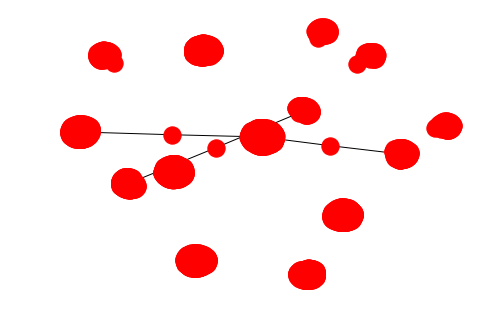

In [51]:
%matplotlib inline
nx.draw(graph)